DIEBOLD-LI 2006, "Forecasting the Term Structure of Government Bond Yields", i.e. the Yield Curve

Author: [@sparshsah](https://github.com/sparshsah)

In [56]:
from typing import Final, Sequence

import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.ar_model as sm_ar

# https://github.com/sparshsah/foggy-statslib/blob/main/foggy_statslib/core.py
import foggy_statslib.core as fsc

# DATA

In [86]:
YCS: Final[pd.DataFrame] = (
    pd.read_csv(
        "data/treasury-gov_daily-treasury-par-yield-curve-rates.csv",
        index_col="Date",
        parse_dates=True,
    )
    .sort_index()
    .rename_axis(index="date")
    .rename(
        columns=lambda n_mo: (
            int(n_mo.split()[0]) if n_mo.split()[1] == "Mo"
            else (
                int(n_mo.split()[0])*12 if n_mo.split()[1] == "Yr"
                else int("ERR")
            )            
        )
    )
    / 100
)
YCS.loc[:, 0] = 0
YCS = YCS.sort_index(axis="columns")

YCS.describe()

,0,1,2,3,4,6,12,24,36,60,84,120,240,360
count,8008.0,5108.000000,803.000000,8004.000000,0.0,8007.000000,8007.000000,8007.000000,8007.000000,8007.000000,8007.000000,8007.000000,7068.000000,7013.000000
mean,0.0,0.011893,0.009332,0.026178,NaN,0.027428,0.028642,0.031560,0.033691,0.037591,0.040643,0.043008,0.043998,0.048258
std,0.0,0.014544,0.010175,0.023005,NaN,0.023387,0.023428,0.023723,0.023281,0.022239,0.021388,0.020370,0.017212,0.019750
min,0.0,0.000000,0.000000,0.000000,NaN,0.000200,0.000400,0.000900,0.001000,0.001900,0.003600,0.005200,0.008700,0.009900
25%,0.0,0.000600,0.000600,0.001600,NaN,0.002600,0.004300,0.008100,0.011500,0.017100,0.021400,0.024950,0.027900,0.030400
50%,0.0,0.005100,0.001200,0.021000,NaN,0.021800,0.023900,0.027400,0.029700,0.035100,0.038900,0.042200,0.045700,0.046600
75%,0.0,0.018000,0.020700,0.049300,NaN,0.050700,0.050500,0.052400,0.054200,0.056500,0.058500,0.059000,0.057600,0.063900
max,0.0,0.052700,0.024800,0.082600,NaN,0.084900,0.086400,0.090500,0.091100,0.091000,0.091200,0.090900,0.083000,0.091800


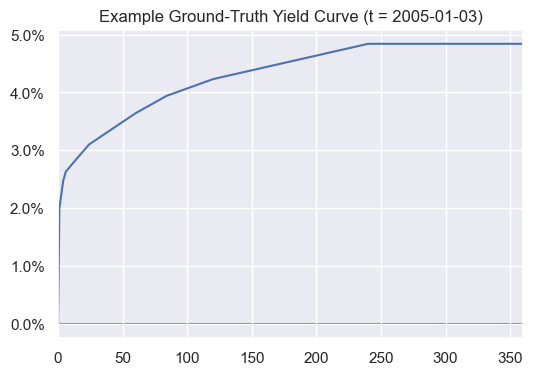

<Axes: title={'center': 'Example Ground-Truth Yield Curve (t = 2005-01-03)'}>

In [97]:
t = "2005-01-03"
fsc.plot(
    YCS.loc[t, :].interpolate(),
    ypct=True,
    title=f"Example Ground-Truth Yield Curve (t = {t})",
    figsize=(6,4),
)

# MODEL

Modified Nelson-Siegel:

$$ y^\tau_t := \beta^1_t + \beta^2_t\left(\frac{1 - e^{-\lambda\tau}}{\lambda\tau}\right) + \beta^3_t\left(\frac{1 - e^{-\lambda\tau}}{\lambda\tau} - e^{-\lambda\tau}\right) ,$$

with $\lambda := 0.0609$ set somewhat arbitrarily so that $1.793/\lambda := 30,$ where $1.793$ is some "point of maximum loading on the curvature factor", otherwise known as the "medium-term factor", and $30$ months is apparently what people consider a medium-term Treasury Note. No idea what's going on here, and the authors give no further explanation or evidence for this.

Therefore, we can simplify this to
$$ y^\tau_t := \beta^1_t + \beta^2_t\left(\frac{1 - e^{-0.0609\tau}}{0.0609\tau}\right) + \beta^3_t\left(\frac{1 - e^{-0.0609\tau}}{0.0609\tau} - e^{-0.0609\tau}\right) $$
$$ = \beta^1_t + \beta^2_t\left(\frac{1 - 0.9409^\tau}{0.0609\tau}\right) + \beta^3_t\left(\frac{1 - 0.9409^\tau}{0.0609\tau} - 0.9409^\tau\right) .$$

Let us define $x^{2,\tau}_t$ to be the factor on $\beta^2_t$ and $x^{3,\tau}_t$ similarly for $\beta^3_t$.

I am going to tweak this a bit by actually redefining $x2 := -x2$ and $x3 := -x3$. This makes the $\beta$'s signs more intuitive, as it will on average have positive loading on the level and slope (representing a climb over maturities) and negative on the curvature (representing a flattening out over maturities).

In [41]:
_get_x3(1)

0.029241510564207207

In [42]:
_get_x3(100)

0.16156621523710452

In [53]:
L: Final[float] = 0.0609
TAUS: Final[Sequence[int]] = list(YCS.columns)

def _get_x2(
    tau: int = 0,
    l: float = L,
) -> float:
    wtf = math.exp(- l*tau)
    numerator =  1 - wtf
    denominator = l * tau
    x2 = numerator / denominator
    return -x2


def _get_x3(
    tau: int = 0,
    l: float = L,
) -> float:
    wtf = math.exp(- l*tau)
    numerator =  1 - wtf
    denominator = l * tau
    x2 = numerator / denominator
    x3 = x2 - wtf
    return -x3


def _get_y(
    tau: int = 0,
    beta1: float = 0.10,
    beta2: float = 0.10,
    beta3: float = -0.10,
) -> float:
    return 0 if tau == 0 else beta1 + beta2*_get_x2(tau=tau) + beta3*_get_x3(tau=tau)

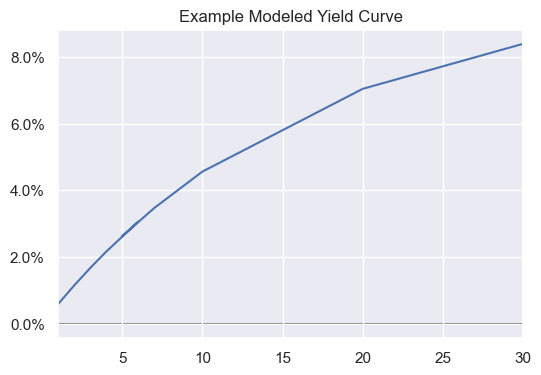

<Axes: title={'center': 'Example Modeled Yield Curve'}>

In [98]:
fsc.plot(
    pd.Series(
        {
            tau: _get_y(
                tau=tau,
            )
            for tau in TAUS
        }
    ),
    ypct=True,
    title="Example Modeled Yield Curve",
    figsize=(6,4)
)